In [2]:
import numpy as np
#import gensim, logging
import csv, string
import nltk
#nltk.download('punkt')
#nltk.download('stopwords')
from nltk.tokenize import word_tokenize
#from nltk.stem.porter import PorterStemmer
import pandas as pd
import tensorflow as tf
import os
import pickle

num_words = 100
num_words_description = 100
directory_prefix = "./"
label_depth = 3
import random
#import gensim.downloader as api
#from nltk.corpus import stopwords
from gensim.parsing.preprocessing import remove_stopwords

#s=set(stopwords.words('english'))
#wv = gensim.models.KeyedVectors.load(directory_prefix+"/patents-small.wv", mmap='r')
#wv = api.load("glove-wiki-gigaword-50")

#porter = PorterStemmer()

#placeholder_vec = [0 for _ in range(embedding_dim)]

#def get_sentence_vector(sentence, num_words):
#   ret = []
#   sentence = map(lambda w: porter.stem(w.lower()), sentence)  
#   for word in sentence:
#       try:
#           ret.append(wv[word])
#       except:
#           pass
#   while len(ret) < num_words:#
#       ret.append(placeholder_vec)
#   return np.vstack(ret[:num_words])

import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1")
embeddings = embed(["cat is on the mat", "dog is in the fog"])
embedding_dim = embeddings.shape[1]


print(embeddings)
def get_sentence_vector(words, num_words):
    words = word_tokenize(remove_stopwords(words))
    ret = embed(words)
    ret = tf.pad(ret, tf.constant([[0, max(0, num_words-ret.shape[0]),], [0, 0]]), "CONSTANT")
    ret = ret[:num_words]
    return ret
 
with open(directory_prefix+"/class_descriptions_from_patents.pickle", 'rb') as f:
    label_dict = pickle.load(f)
#label_dict = {k[:label_depth]: get_sentence_vector(word_tokenize(remove_stopwords(val.lower())), num_words_description) for k, val in label_dict.items()}
label_dict = {k[:label_depth]: get_sentence_vector(val.lower(), num_words_description) for k, val in label_dict.items()}

label_dict_keys = set(label_dict.keys())


tf.Tensor(
[[ 0.27107972 -0.01055073 -0.05728397  0.06853679 -0.08438271  0.22396211
  -0.00247001 -0.09797598 -0.06092518  0.01678422  0.0183306  -0.02683547
   0.01987647  0.02205245  0.0380337   0.02345292 -0.0535214  -0.02916854
  -0.13816142  0.255649    0.00548296  0.08994407  0.09702856 -0.01617393
   0.15273312  0.03449007  0.05599031  0.01964826 -0.01901525  0.11601479
   0.06575833 -0.03560898 -0.02412845 -0.00716866 -0.08950593 -0.01021391
   0.07431487 -0.10462939 -0.03951982  0.00272066 -0.01468687 -0.01350653
  -0.04825642  0.03088917 -0.0448269  -0.01743765  0.1034883   0.04149228
  -0.03979184  0.03878277  0.15273733 -0.09228262 -0.01723959  0.01830614
  -0.02075483  0.0800882  -0.08071491 -0.15573218  0.13893387  0.06140287
  -0.05639812 -0.05526257 -0.02765993 -0.175832    0.01034007 -0.19550695
   0.06209265 -0.03193678  0.08837268 -0.05629309  0.09268684  0.05395978
  -0.01900527 -0.17626993 -0.03103094 -0.12204378 -0.00157093 -0.07853678
  -0.05892268  0.11311311  

In [3]:
print(embedding_dim)

128


In [ ]:
def lstm_data_generator():
    current_dataframe = pd.read_csv(directory_prefix+'/dataset.csv',sep=',', header = None).to_numpy()#, chunksize=100000)
    indices = np.random.choice(300000, 200000)
    for row in current_dataframe[indices]:
        label, description=row[0], row[1]
        #lstm_input_patent = get_sentence_vector(word_tokenize(description.lower()), num_words)
        lstm_input_patent = get_sentence_vector(description.lower(), num_words)

        label_vectors = [z.strip().strip('\'\"')[:label_depth] for z in label.split(',')]
        label_vectors = set([i for i in label_vectors if i in label_dict_keys])
        non_true_vectors = [label_dict[i] for i in random.sample(label_dict_keys, min(len(label_vectors), len(label_dict.keys()))) if i not in label_vectors]
        for l in (label_dict[i] for i in label_vectors):
            yield ({'input_1':lstm_input_patent, 'input_2':l}, {'output_binary':[1]})
        for l in non_true_vectors:
            yield ({'input_1':lstm_input_patent, 'input_2':l}, {'output_binary':[0]})

lstm_dataset = tf.data.Dataset.from_generator(lstm_data_generator, ({'input_1':tf.float64, 'input_2':tf.float64}, {'output_binary':tf.float64}), ({'input_1':tf.TensorShape([num_words, embedding_dim]), 'input_2':tf.TensorShape([num_words_description, embedding_dim])}, {'output_binary':tf.TensorShape([1])}))
lstm_dataset = lstm_dataset.batch(32, drop_remainder=True).prefetch(100).repeat()


In [ ]:

#attention layer from https://www.analyticsvidhya.com/blog/2019/11/comprehensive-guide-attention-mechanism-deep-learning/
import keras
from keras.layers import Layer
import keras.backend as K
class attention(Layer):
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(attention,self).__init__()
        
    def build(self, input_shape):
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),initializer="zeros")
        
        super(attention,self).build(input_shape)
        
    def call(self, x):
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        
        if self.return_sequences:
            return output
        
        return K.sum(output, axis=1)
    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()




input_lstm = tf.keras.Input(shape=(num_words, embedding_dim), name='input_1')
input_label = tf.keras.Input(shape=(num_words_description, embedding_dim), name='input_2')

patent_mask = tf.keras.layers.Masking(mask_value=0., input_shape=(num_words, embedding_dim))(input_lstm)
label_mask = tf.keras.layers.Masking(mask_value=0., input_shape=(num_words_description, embedding_dim))(input_label)

layer_size = 2048
#patent = tf.keras.layers.LSTM(num_words, input_shape=(num_words, embedding_dim), return_sequences=True)(patent_mask)
#label = tf.keras.layers.LSTM(num_words_description, input_shape=(num_words_description, embedding_dim),return_sequences=True)(label_mask)
patent = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(num_words, input_shape=(num_words, embedding_dim), return_sequences=True))(patent_mask)
label = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(num_words_description, input_shape=(num_words_description, embedding_dim),return_sequences=True))(label_mask)

from keras_self_attention import SeqSelfAttention

#from attention import Attention
patent = SeqSelfAttention(attention_activation='tanh', attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL)(patent)
label = SeqSelfAttention(attention_activation='tanh', attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL)(label)
#patent = tf.keras.layers.Attention()(patent)
#label = tf.keras.layers.Attention()(label)
#patent = tf.keras.layers.Attention()([patent,patent_mask])
#label = tf.keras.layers.Attention()([label,label_mask])


patent = tf.keras.layers.GlobalAveragePooling1D()(patent)
label = tf.keras.layers.GlobalAveragePooling1D()(label)

#patent = tf.keras.layers.Dense(layer_size)(patent)
#label =  tf.keras.layers.Dense(layer_size)(label)
#patent = tf.keras.layers.Dense(layer_size)(patent)
#label =  tf.keras.layers.Dense(layer_size)(label)

subtract = tf.keras.layers.Subtract()([patent, label])
multiply = tf.keras.layers.Multiply()([patent, label])

concat = tf.keras.layers.Concatenate(axis=1)([label, patent])
dense = tf.keras.layers.Dense(int(layer_size))(concat)
dense = tf.keras.layers.Dense(int(layer_size))(dense)
dense = tf.keras.layers.Dense(int(layer_size))(dense)
dense = tf.keras.layers.Dense(int(layer_size))(dense)
dense = tf.keras.layers.Dense(int(layer_size))(dense)
dense = tf.keras.layers.Dense(int(layer_size))(dense)
dense = tf.keras.layers.Dense(int(layer_size))(dense)
dense = tf.keras.layers.Dense(int(layer_size))(dense)
dense = tf.keras.layers.Dense(int(layer_size))(dense)
dense = tf.keras.layers.Dense(int(layer_size))(dense)
dense = tf.keras.layers.Dense(int(layer_size))(dense)
dense = tf.keras.layers.Dense(int(layer_size))(dense)

output_binary = tf.keras.layers.Dense(1, name='output_binary')(dense)


#lstm_enforce_1 = tf.keras.layers.Dense(200, activation='relu')(patent_lstm)
#lstm_enforce_2 = tf.keras.layers.Dense(1000, name='output_2')(lstm_enforce_1)
#model = tf.keras.Model(inputs={'input_1':input_lstm, 'input_2':input_label}, outputs={'output_1':output_binary, 'output_2':lstm_enforce_2})
model = tf.keras.Model(inputs={'input_1':input_lstm, 'input_2':input_label}, outputs=[output_binary])
print(model)

In [ ]:
print(len(label_dict))

In [82]:
#saver = tf.train.Saver(max_to_keep=4, keep_checkpoint_every_n_hours=2)
#del model
try:
    model.load_weights(directory_prefix+"/doublelstmcheckpoint2.h5")
except:
    pass

model.summary()
opt = tf.optimizers.Adam()
model.compile(loss=['binary_crossentropy'],
              optimizer='adam',
              metrics=['accuracy'], experimental_run_tf_function=False)


# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=directory_prefix+"/doublelstmcheckpoint1.h5",
                                                 save_weights_only=False,
                                                 verbose=1)

class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        generate_prc()
prc_callback = CustomCallback()

Model: "functional_33"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 128)]   0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 100, 128)]   0                                            
__________________________________________________________________________________________________
masking_45 (Masking)            (None, 100, 128)     0           input_2[0][0]                    
__________________________________________________________________________________________________
masking_44 (Masking)            (None, 100, 128)     0           input_1[0][0]                    
______________________________________________________________________________________

In [83]:
def generate_prc():
    label_len = len(label_dict_keys)
    print(label_len)
    left = [label_dict[i] for i in label_dict_keys]
    predictions = []
    left_vectors = np.array(list(label_dict.keys()))
    label_vectors_vector = []
    num_tests = 1000
    def cur_gen():
        current_dataframe = pd.read_csv(directory_prefix+'/test_dataset.csv',sep=',', header = None).to_numpy()
        indices = np.random.choice(7215, num_tests)
        for row in current_dataframe[indices]:
            label, description=row[0], row[1]
            label_vectors = [z.strip().strip('\'\"')[:label_depth] for z in label.split(',')]
            label_vectors = set([i for i in label_vectors if i in label_dict_keys])
            if label_vectors == set():
                continue
            label_vectors_vector.append(label_vectors)
            lstm_input_patent =  get_sentence_vector(description.lower(), num_words)
            for i in left:
                yield ({'input_1':lstm_input_patent, 'input_2':i})

    dataset = tf.data.Dataset.from_generator(cur_gen, ({'input_1':tf.float64, 'input_2':tf.float64}), ({'input_1':tf.TensorShape([num_words, embedding_dim]), 'input_2':tf.TensorShape([num_words_description, embedding_dim])}))
    dataset = dataset.batch(label_len).prefetch(50)
    predictions = model.predict(dataset, steps=num_tests, verbose=1).reshape(num_tests, label_len)
    n = 0
    d=0
    ns = []
    recalls = np.arange(0, 1.01, .1)
    ns = []
    for prediction, label_vectors in zip(predictions, label_vectors_vector):
        indices = np.flip(np.argsort(prediction, axis=0))
        e = [1 if i in label_vectors else 0 for i in left_vectors[indices]]
        cur = []
        total_ones = e.count(1)
        n = 0
        ones_seen = 0
        while ones_seen < total_ones:
            if e[n] == 1:
                ones_seen = ones_seen+1
            n = n+1
            cur.append((ones_seen/float(n), ones_seen/float(total_ones)))
        new_cur = []
        for r in recalls:
            max_of_larger = max([i[0] for i in cur if i[1] >= r])
            new_cur.append(max_of_larger)
        ns.append(new_cur)
        #print(max(new_cur))
        d = d+1
        #print(float(d)/7215)
        #print(np.mean(np.vstack(ns), axis=0)[0])
    p = np.mean(np.array(ns), axis=0)
    np.save("newest_ps.npy", p)
    np.save("predictions.npy", predictions)
    np.save("label_vectors_vector.npy", label_vectors_vector)
    import matplotlib.pyplot as plt
    plt.plot(recalls, p)
    plt.ylim(0, 1)
    plt.xlim(0, 1)
    plt.margins(0.1)
    #plt.xticks(range(len(distribution_dict.keys()))[::50], new_x[::50], rotation='vertical')
    plt.ylabel('Precision', fontsize=16)
    plt.xlabel('Recall', fontsize=16)
    plt.tight_layout()
    plt.show()
    print(p) 
    plt.savefig('binary_prc1.eps', format='eps')

Epoch 1/50
 999/1000 [============================>.] - ETA: 0s - loss: 106.7670 - accuracy: 0.6047
Epoch 00001: saving model to ./doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 37s 37ms/step


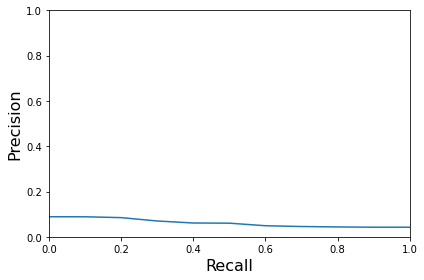

[0.08863588 0.08838588 0.08467723 0.06984173 0.06093544 0.06017121
 0.04887884 0.04542207 0.04356228 0.04233166 0.0423225 ]
1000/1000 [==============================] - 104s 104ms/step - loss: 106.6611 - accuracy: 0.6046
Epoch 2/50
1000/1000 [==============================] - ETA: 0s - loss: 0.6046 - accuracy: 0.6843
Epoch 00002: saving model to ./doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 39s 39ms/step


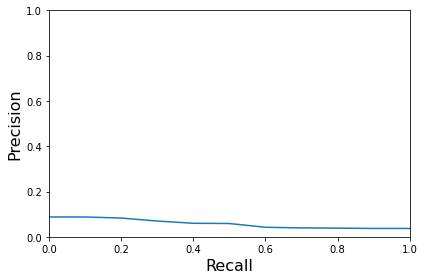

[0.0876741  0.08745886 0.08285936 0.06958331 0.05979232 0.05867792
 0.04206362 0.039367   0.03822922 0.03682709 0.03681019]
1000/1000 [==============================] - 95s 95ms/step - loss: 0.6046 - accuracy: 0.6843
Epoch 3/50
1000/1000 [==============================] - ETA: 0s - loss: 0.5347 - accuracy: 0.7351
Epoch 00003: saving model to ./doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 39s 39ms/step


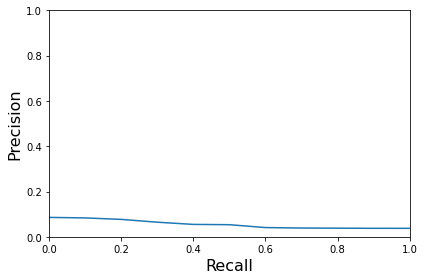

[0.08572265 0.08342775 0.07692321 0.06451861 0.05476247 0.05344789
 0.04079627 0.03871589 0.03810687 0.03749378 0.03746286]
1000/1000 [==============================] - 96s 96ms/step - loss: 0.5347 - accuracy: 0.7351
Epoch 4/50
1000/1000 [==============================] - ETA: 0s - loss: 0.5133 - accuracy: 0.7487
Epoch 00004: saving model to ./doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 39s 39ms/step


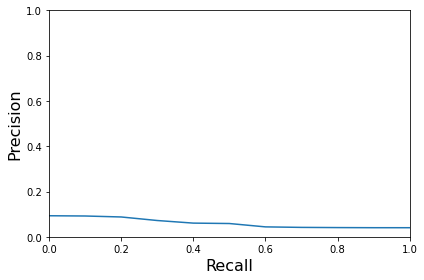

[0.09301307 0.09187974 0.08757608 0.07194482 0.06044562 0.05866273
 0.043826   0.04156438 0.04071916 0.04020579 0.0401418 ]
1000/1000 [==============================] - 95s 95ms/step - loss: 0.5133 - accuracy: 0.7487
Epoch 5/50
1000/1000 [==============================] - ETA: 0s - loss: 0.5019 - accuracy: 0.7591
Epoch 00005: saving model to ./doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 39s 39ms/step


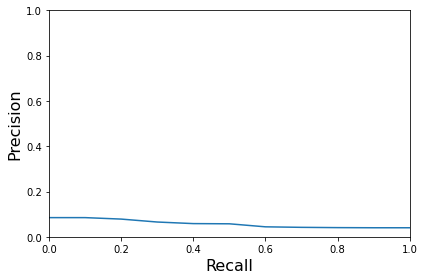

[0.08470937 0.08470937 0.07822745 0.06526949 0.05829145 0.0573992
 0.04407187 0.04177415 0.04055102 0.03995759 0.03992477]
1000/1000 [==============================] - 96s 96ms/step - loss: 0.5019 - accuracy: 0.7591
Epoch 6/50
1000/1000 [==============================] - ETA: 0s - loss: 0.4918 - accuracy: 0.7661
Epoch 00006: saving model to ./doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 39s 39ms/step


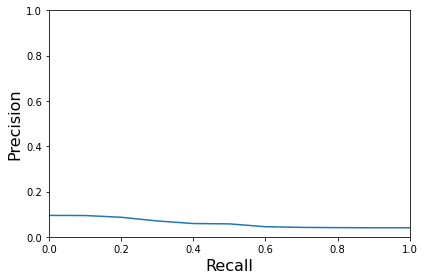

[0.09448405 0.09398347 0.08619704 0.07004833 0.05863228 0.0570577
 0.04454043 0.04158015 0.04050941 0.03988882 0.03983514]
1000/1000 [==============================] - 96s 96ms/step - loss: 0.4918 - accuracy: 0.7661
Epoch 7/50
1000/1000 [==============================] - ETA: 0s - loss: 0.4864 - accuracy: 0.7762
Epoch 00007: saving model to ./doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 39s 39ms/step


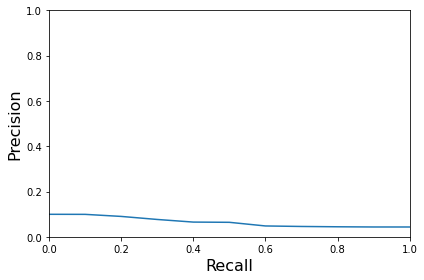

[0.09938873 0.09911096 0.09001208 0.07657285 0.06498278 0.06398588
 0.04789074 0.04564703 0.04425153 0.04335234 0.04331285]
1000/1000 [==============================] - 96s 96ms/step - loss: 0.4864 - accuracy: 0.7762
Epoch 8/50
1000/1000 [==============================] - ETA: 0s - loss: 0.4877 - accuracy: 0.7715
Epoch 00008: saving model to ./doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 39s 39ms/step


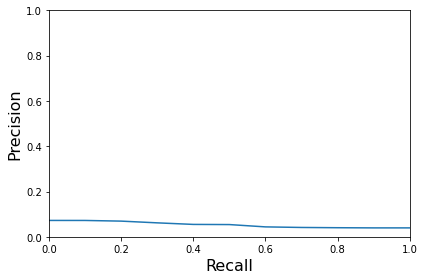

[0.07229328 0.07220368 0.0692474  0.06161025 0.05472975 0.0540207
 0.04379542 0.04125258 0.04011688 0.0393866  0.03938203]
1000/1000 [==============================] - 96s 96ms/step - loss: 0.4877 - accuracy: 0.7715
Epoch 9/50
1000/1000 [==============================] - ETA: 0s - loss: 0.4901 - accuracy: 0.7723
Epoch 00009: saving model to ./doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 39s 39ms/step


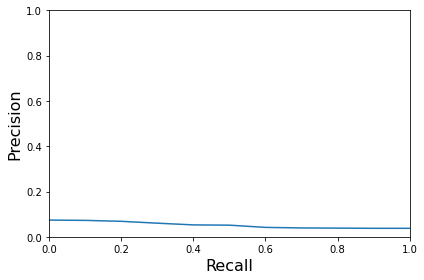

[0.07381293 0.07251635 0.06842145 0.06014895 0.05258043 0.05138176
 0.04154237 0.03916215 0.03831443 0.03746484 0.03745506]
1000/1000 [==============================] - 97s 97ms/step - loss: 0.4901 - accuracy: 0.7723
Epoch 10/50
 999/1000 [============================>.] - ETA: 0s - loss: 0.4812 - accuracy: 0.7801
Epoch 00010: saving model to ./doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 39s 39ms/step


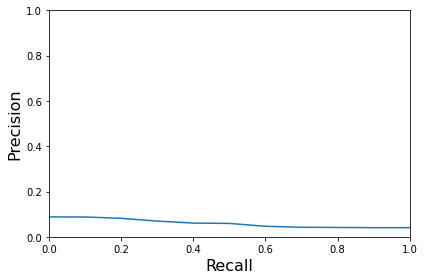

[0.08770884 0.08752134 0.08158218 0.06942878 0.06058058 0.05914177
 0.04642904 0.04208587 0.04126312 0.04031581 0.04030308]
1000/1000 [==============================] - 96s 96ms/step - loss: 0.4814 - accuracy: 0.7801
Epoch 11/50
1000/1000 [==============================] - ETA: 0s - loss: 0.4869 - accuracy: 0.7751
Epoch 00011: saving model to ./doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 39s 39ms/step


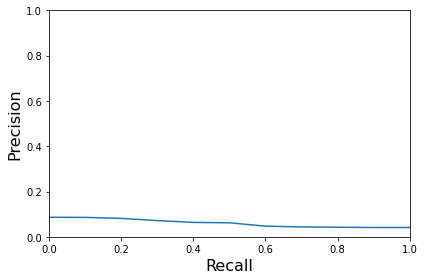

[0.08624794 0.08569508 0.08141741 0.07162155 0.06359432 0.06194099
 0.04705107 0.04356481 0.04227495 0.04105611 0.04099251]
1000/1000 [==============================] - 96s 96ms/step - loss: 0.4869 - accuracy: 0.7751
Epoch 12/50
1000/1000 [==============================] - ETA: 0s - loss: 0.4916 - accuracy: 0.7805
Epoch 00012: saving model to ./doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 39s 39ms/step


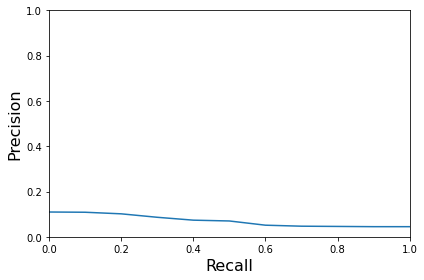

[0.10947957 0.1084515  0.10145203 0.08619946 0.07349068 0.06990003
 0.05127326 0.04683833 0.04580192 0.044735   0.04468389]
1000/1000 [==============================] - 96s 96ms/step - loss: 0.4916 - accuracy: 0.7805
Epoch 13/50
1000/1000 [==============================] - ETA: 0s - loss: 35796209664.0000 - accuracy: 0.6033
Epoch 00013: saving model to ./doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 39s 39ms/step


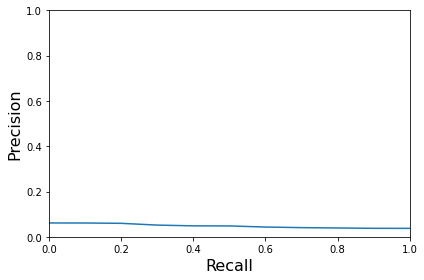

[0.06113306 0.06096237 0.05952624 0.0516798  0.04838619 0.04799716
 0.04312367 0.04052434 0.03898439 0.03742928 0.03728351]
1000/1000 [==============================] - 95s 95ms/step - loss: 35796209664.0000 - accuracy: 0.6033
Epoch 14/50
1000/1000 [==============================] - ETA: 0s - loss: 16277769.0000 - accuracy: 0.5245
Epoch 00014: saving model to ./doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 39s 39ms/step


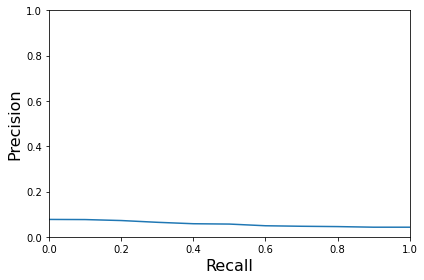

[0.07668004 0.0761164  0.0718419  0.06401985 0.05773431 0.05621853
 0.04879639 0.04652998 0.04509793 0.04241297 0.04236955]
1000/1000 [==============================] - 96s 96ms/step - loss: 16277769.0000 - accuracy: 0.5245
Epoch 15/50
1000/1000 [==============================] - ETA: 0s - loss: 10354990.0000 - accuracy: 0.5218
Epoch 00015: saving model to ./doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 39s 39ms/step


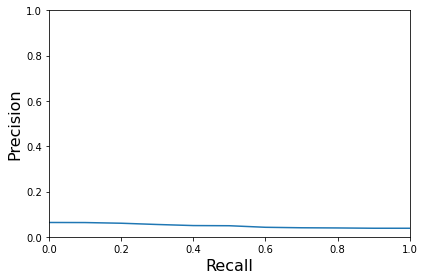

[0.06322277 0.06290965 0.05992695 0.05438523 0.04961855 0.04888071
 0.04203024 0.03989939 0.03908728 0.03778211 0.03771006]
1000/1000 [==============================] - 96s 96ms/step - loss: 10354990.0000 - accuracy: 0.5218
Epoch 16/50
1000/1000 [==============================] - ETA: 0s - loss: 5467717.5000 - accuracy: 0.5274
Epoch 00016: saving model to ./doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 39s 39ms/step


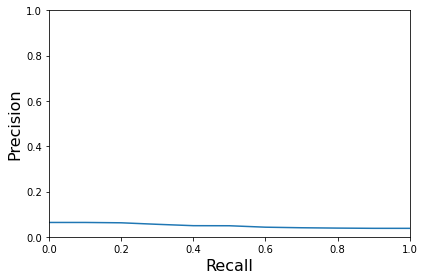

[0.06334631 0.06334631 0.06185054 0.05516391 0.04911565 0.04880375
 0.0424524  0.03997076 0.0384369  0.0374146  0.03735304]
1000/1000 [==============================] - 96s 96ms/step - loss: 5467717.5000 - accuracy: 0.5274
Epoch 17/50
1000/1000 [==============================] - ETA: 0s - loss: 4505105.0000 - accuracy: 0.5573
Epoch 00017: saving model to ./doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 40s 40ms/step


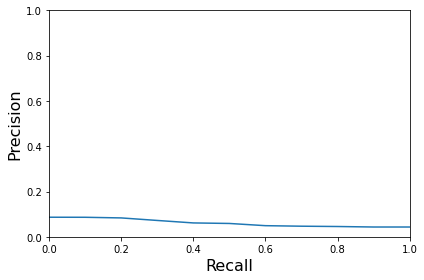

[0.08645706 0.08620769 0.08339973 0.07221663 0.06126034 0.05891155
 0.04915754 0.04680355 0.04545281 0.0432327  0.0432327 ]
1000/1000 [==============================] - 97s 97ms/step - loss: 4505105.0000 - accuracy: 0.5573
Epoch 18/50
1000/1000 [==============================] - ETA: 0s - loss: 2215470.7500 - accuracy: 0.6120
Epoch 00018: saving model to ./doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 39s 39ms/step


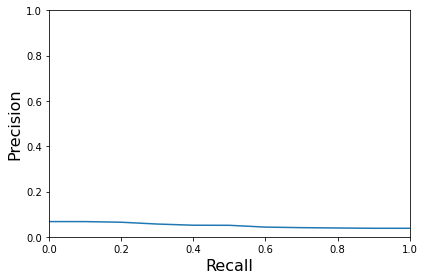

[0.06722342 0.06714234 0.06437947 0.0563529  0.05113048 0.05076351
 0.04277928 0.04042705 0.03889794 0.03764815 0.03758523]
1000/1000 [==============================] - 96s 96ms/step - loss: 2215470.7500 - accuracy: 0.6120
Epoch 19/50
1000/1000 [==============================] - ETA: 0s - loss: 3391852.0000 - accuracy: 0.6337
Epoch 00019: saving model to ./doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 39s 39ms/step


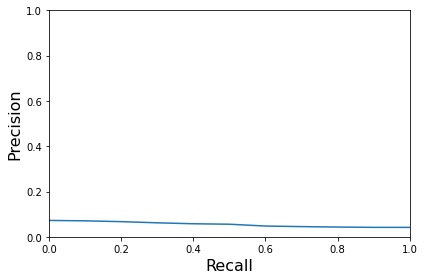

[0.07234707 0.0705317  0.06694941 0.06174802 0.05760433 0.05555339
 0.04749109 0.0450043  0.04305079 0.04164158 0.04155836]
1000/1000 [==============================] - 96s 96ms/step - loss: 3391852.0000 - accuracy: 0.6337
Epoch 20/50
 999/1000 [============================>.] - ETA: 0s - loss: 1576621.2500 - accuracy: 0.6512
Epoch 00020: saving model to ./doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 39s 39ms/step


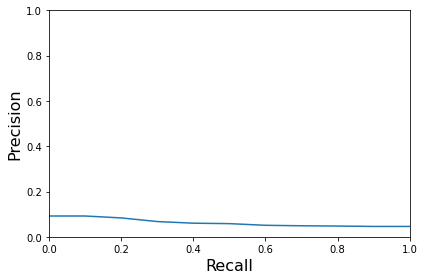

[0.09184925 0.09184622 0.0834034  0.06736233 0.06010231 0.05811859
 0.05080209 0.04872781 0.04748319 0.0458026  0.0457547 ]
1000/1000 [==============================] - 95s 95ms/step - loss: 1575105.2500 - accuracy: 0.6513
Epoch 21/50
1000/1000 [==============================] - ETA: 0s - loss: 1618118.1250 - accuracy: 0.6609
Epoch 00021: saving model to ./doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 39s 39ms/step


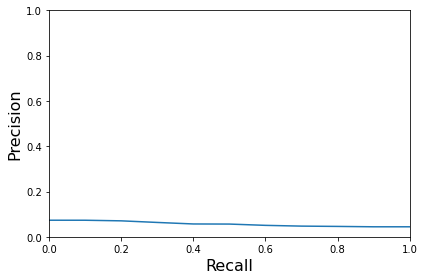

[0.0732113  0.07315599 0.07049462 0.06340327 0.05669346 0.05623132
 0.05054488 0.04719102 0.04587575 0.04420848 0.0441878 ]
1000/1000 [==============================] - 96s 96ms/step - loss: 1618118.1250 - accuracy: 0.6609
Epoch 22/50
1000/1000 [==============================] - ETA: 0s - loss: 1013402.5625 - accuracy: 0.6836
Epoch 00022: saving model to ./doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 39s 39ms/step


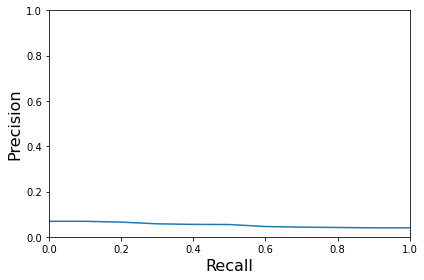

[0.06850765 0.06846843 0.06485709 0.05732913 0.05484538 0.05421792
 0.04531522 0.04257195 0.04116701 0.039678   0.03958142]
1000/1000 [==============================] - 96s 96ms/step - loss: 1013402.5625 - accuracy: 0.6836
Epoch 23/50
1000/1000 [==============================] - ETA: 0s - loss: 31899322368.0000 - accuracy: 0.6670
Epoch 00023: saving model to ./doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 40s 40ms/step


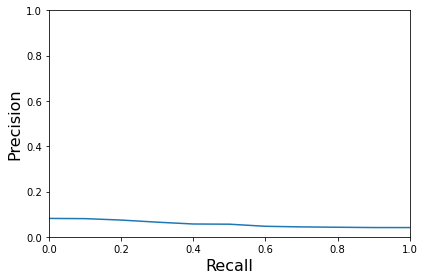

[0.08117368 0.08022368 0.07391944 0.06460463 0.05654334 0.05567895
 0.04643216 0.04375609 0.04220549 0.04087447 0.04076353]
1000/1000 [==============================] - 97s 97ms/step - loss: 31899322368.0000 - accuracy: 0.6670
Epoch 24/50
1000/1000 [==============================] - ETA: 0s - loss: 88561864.0000 - accuracy: 0.589 - ETA: 0s - loss: 88484232.0000 - accuracy: 0.5890
Epoch 00024: saving model to ./doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 39s 39ms/step


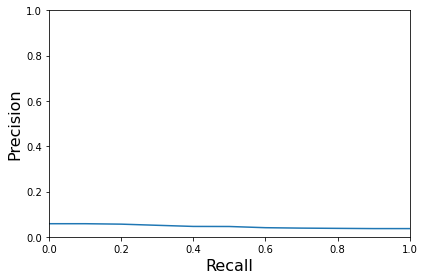

[0.05781882 0.05781882 0.05587288 0.05080891 0.04582867 0.04550198
 0.04021818 0.03834357 0.03727041 0.03624312 0.03620601]
1000/1000 [==============================] - 96s 96ms/step - loss: 88484232.0000 - accuracy: 0.5890
Epoch 25/50
1000/1000 [==============================] - ETA: 0s - loss: 13796622.0000 - accuracy: 0.5920
Epoch 00025: saving model to ./doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 39s 39ms/step


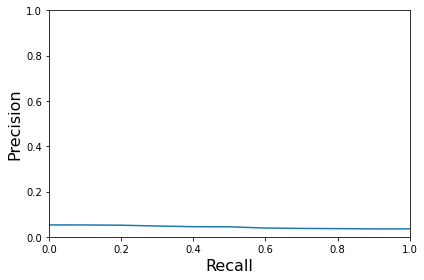

[0.05238982 0.05233268 0.05119524 0.04761339 0.04462468 0.04413862
 0.03865291 0.03704042 0.03610454 0.03487646 0.03481176]
1000/1000 [==============================] - 96s 96ms/step - loss: 13796622.0000 - accuracy: 0.5920
Epoch 26/50
1000/1000 [==============================] - ETA: 0s - loss: 7892500.0000 - accuracy: 0.5955
Epoch 00026: saving model to ./doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 39s 39ms/step


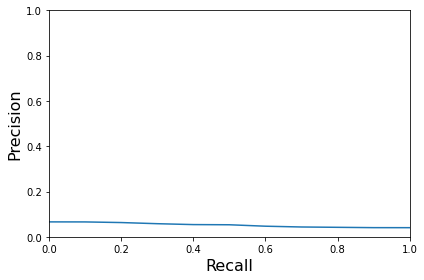

[0.06588278 0.06570097 0.06294023 0.0578806  0.05392396 0.05315281
 0.04680629 0.0433181  0.04189328 0.04043738 0.04031067]
1000/1000 [==============================] - 96s 96ms/step - loss: 7892500.0000 - accuracy: 0.5955
Epoch 27/50
 999/1000 [============================>.] - ETA: 0s - loss: 5962323.0000 - accuracy: 0.5971
Epoch 00027: saving model to ./doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 39s 39ms/step


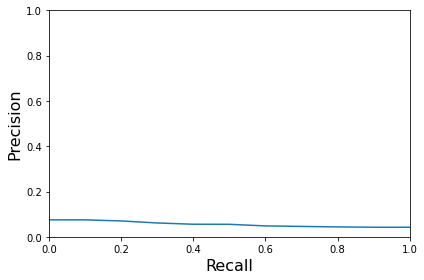

[0.07491439 0.07491439 0.07001895 0.06108811 0.05547628 0.05513262
 0.0481123  0.04584919 0.04369831 0.04228737 0.04221025]
1000/1000 [==============================] - 96s 96ms/step - loss: 5963167.5000 - accuracy: 0.5972
Epoch 28/50
1000/1000 [==============================] - ETA: 0s - loss: 3999468.5000 - accuracy: 0.6062
Epoch 00028: saving model to ./doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 39s 39ms/step


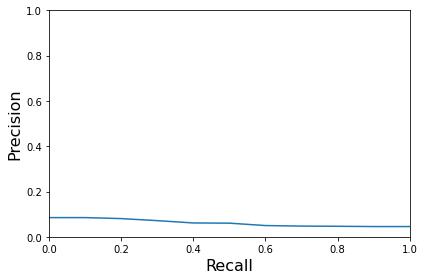

[0.08482182 0.08482182 0.08039821 0.07139752 0.06116679 0.06024267
 0.04967222 0.04729618 0.04645315 0.04525739 0.04522128]
1000/1000 [==============================] - 96s 96ms/step - loss: 3999468.5000 - accuracy: 0.6062
Epoch 29/50
1000/1000 [==============================] - ETA: 0s - loss: 4643248.0000 - accuracy: 0.5983
Epoch 00029: saving model to ./doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 39s 39ms/step


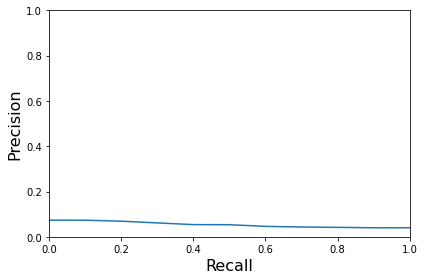

[0.07350921 0.07332972 0.06898566 0.06136637 0.05383918 0.05334182
 0.0460915  0.04315807 0.04171547 0.03991308 0.03987526]
1000/1000 [==============================] - 96s 96ms/step - loss: 4643248.0000 - accuracy: 0.5983
Epoch 30/50
1000/1000 [==============================] - ETA: 0s - loss: 2194107.2500 - accuracy: 0.6211
Epoch 00030: saving model to ./doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 39s 39ms/step


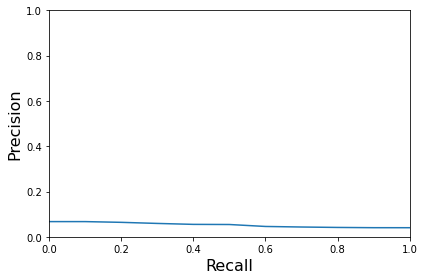

[0.06711048 0.06711048 0.06387958 0.05906138 0.05489276 0.05429829
 0.04568925 0.04321671 0.04135547 0.04024754 0.04015398]
1000/1000 [==============================] - 95s 95ms/step - loss: 2194107.2500 - accuracy: 0.6211
Epoch 31/50
1000/1000 [==============================] - ETA: 0s - loss: 2199695.0000 - accuracy: 0.6193
Epoch 00031: saving model to ./doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 39s 39ms/step


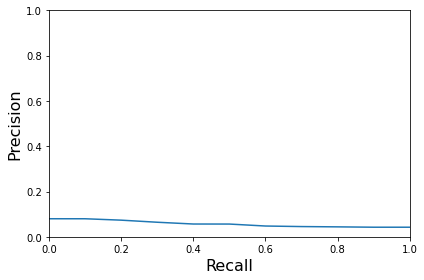

[0.07973897 0.07969135 0.07348845 0.06429226 0.05646434 0.05627142
 0.04761517 0.04519581 0.04390336 0.04234157 0.04233847]
1000/1000 [==============================] - 96s 96ms/step - loss: 2199695.0000 - accuracy: 0.6193
Epoch 32/50
1000/1000 [==============================] - ETA: 0s - loss: 2085988.3750 - accuracy: 0.6235
Epoch 00032: saving model to ./doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 39s 39ms/step


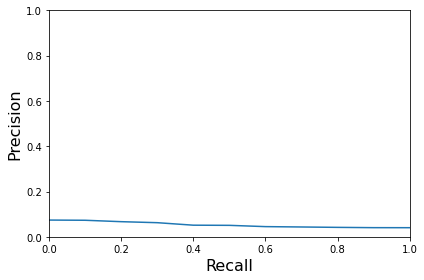

[0.07390703 0.0730369  0.06680272 0.06233236 0.05128573 0.05059972
 0.04496526 0.04335101 0.04166344 0.04036606 0.04022382]
1000/1000 [==============================] - 98s 98ms/step - loss: 2085988.3750 - accuracy: 0.6235
Epoch 33/50
1000/1000 [==============================] - ETA: 0s - loss: 193455.6094 - accuracy: 0.6483
Epoch 00033: saving model to ./doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 39s 39ms/step


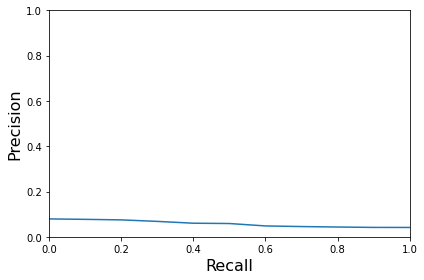

[0.07894357 0.07707842 0.07475933 0.06806285 0.06000318 0.0586471
 0.04800649 0.04525415 0.04317512 0.04146072 0.04128722]
1000/1000 [==============================] - 96s 96ms/step - loss: 193455.6094 - accuracy: 0.6483
Epoch 34/50
1000/1000 [==============================] - ETA: 0s - loss: 109596.6250 - accuracy: 0.6521
Epoch 00034: saving model to ./doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 39s 39ms/step


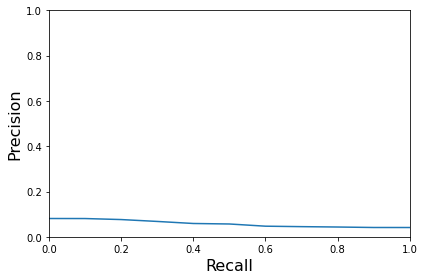

[0.08080184 0.08063517 0.0761618  0.06784445 0.05879065 0.05658543
 0.04687466 0.04486293 0.0432065  0.04110829 0.04101703]
1000/1000 [==============================] - 97s 97ms/step - loss: 109596.6250 - accuracy: 0.6521
Epoch 35/50
 999/1000 [============================>.] - ETA: 0s - loss: 25051736064.0000 - accuracy: 0.5921
Epoch 00035: saving model to ./doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 39s 39ms/step


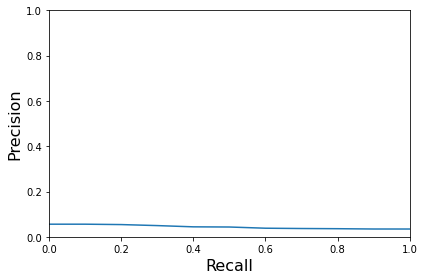

[0.05568873 0.05568873 0.05399997 0.04952105 0.04400638 0.04324028
 0.03794127 0.03659487 0.03577284 0.03441017 0.0343711 ]
1000/1000 [==============================] - 96s 96ms/step - loss: 25026709504.0000 - accuracy: 0.5921
Epoch 36/50
 999/1000 [============================>.] - ETA: 0s - loss: 15194483.0000 - accuracy: 0.6071
Epoch 00036: saving model to ./doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 40s 40ms/step


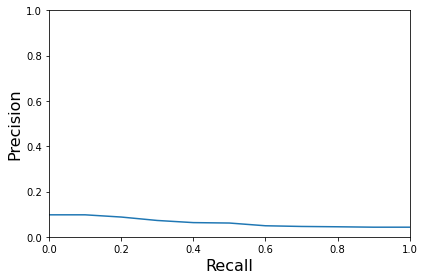

[0.09709444 0.09709444 0.08727452 0.07213604 0.06267938 0.06080883
 0.04875807 0.04569031 0.04427589 0.04243545 0.04243545]
1000/1000 [==============================] - 97s 97ms/step - loss: 15186342.0000 - accuracy: 0.6070
Epoch 37/50
1000/1000 [==============================] - ETA: 0s - loss: 7506960.0000 - accuracy: 0.6129
Epoch 00037: saving model to ./doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 40s 40ms/step


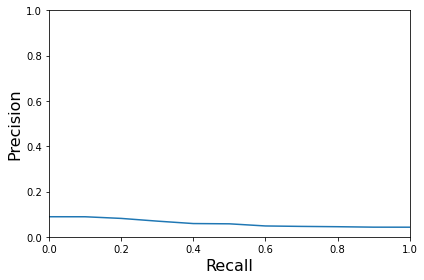

[0.08860538 0.08850538 0.08123985 0.06923101 0.05850814 0.05732685
 0.04787254 0.04592998 0.04456229 0.04255735 0.04239945]
1000/1000 [==============================] - 96s 96ms/step - loss: 7506960.0000 - accuracy: 0.6129
Epoch 38/50
1000/1000 [==============================] - ETA: 0s - loss: 4518377.5000 - accuracy: 0.6244 ETA: 0s - loss: 4522376.0000 - accuracy: 0.62
Epoch 00038: saving model to ./doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 40s 40ms/step


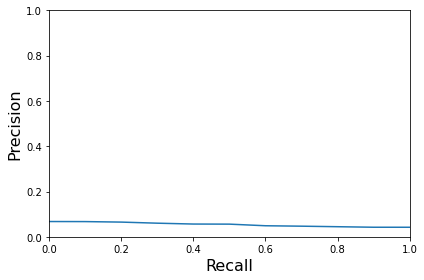

[0.06745336 0.06716027 0.06493421 0.06013489 0.05635569 0.05591762
 0.04880159 0.04688834 0.04455503 0.04221994 0.0421239 ]
1000/1000 [==============================] - 96s 96ms/step - loss: 4518377.5000 - accuracy: 0.6244
Epoch 39/50
1000/1000 [==============================] - ETA: 0s - loss: 3090605.0000 - accuracy: 0.6235
Epoch 00039: saving model to ./doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 40s 40ms/step


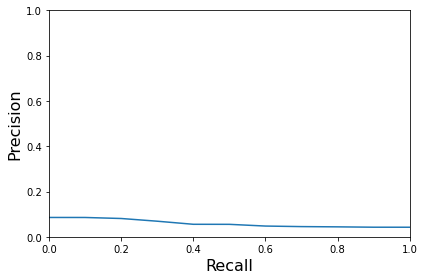

[0.08543749 0.08535393 0.08085605 0.06887136 0.05526165 0.05504762
 0.04746721 0.04505165 0.04393494 0.04234717 0.04225535]
1000/1000 [==============================] - 97s 97ms/step - loss: 3090605.0000 - accuracy: 0.6235
Epoch 40/50
1000/1000 [==============================] - ETA: 0s - loss: 1457591.3750 - accuracy: 0.6317
Epoch 00040: saving model to ./doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 40s 40ms/step


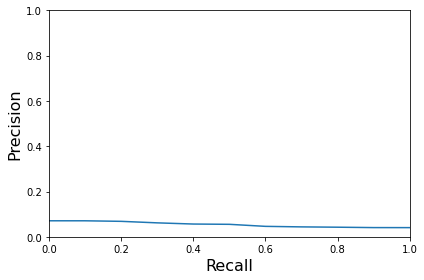

[0.07073158 0.07070778 0.06828154 0.06158474 0.05635731 0.05511904
 0.04614222 0.04379426 0.04239589 0.04066116 0.04052262]
1000/1000 [==============================] - 96s 96ms/step - loss: 1457591.3750 - accuracy: 0.6317
Epoch 41/50
1000/1000 [==============================] - ETA: 0s - loss: 1112483.8750 - accuracy: 0.6295
Epoch 00041: saving model to ./doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 40s 40ms/step


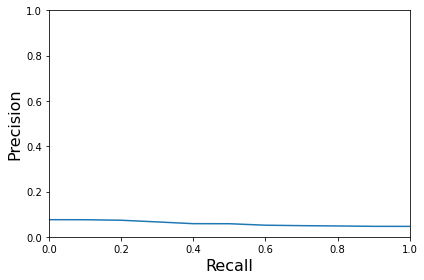

[0.07560103 0.0754177  0.07316387 0.06571487 0.05797966 0.05775126
 0.05118808 0.0492149  0.04786863 0.04619788 0.04599182]
1000/1000 [==============================] - 96s 96ms/step - loss: 1112483.8750 - accuracy: 0.6295
Epoch 42/50
1000/1000 [==============================] - ETA: 0s - loss: 822009.7500 - accuracy: 0.6279
Epoch 00042: saving model to ./doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 40s 40ms/step


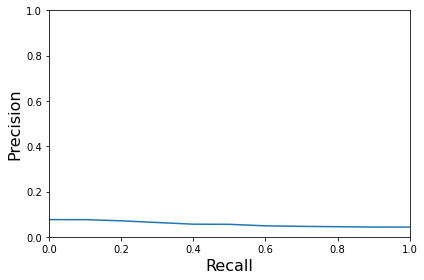

[0.07580912 0.07574516 0.07067002 0.06309661 0.05574948 0.05512707
 0.04838995 0.04607876 0.04459226 0.04293313 0.04287048]
1000/1000 [==============================] - 97s 97ms/step - loss: 822009.7500 - accuracy: 0.6279
Epoch 43/50
1000/1000 [==============================] - ETA: 0s - loss: 910728.0000 - accuracy: 0.6366
Epoch 00043: saving model to ./doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 40s 40ms/step


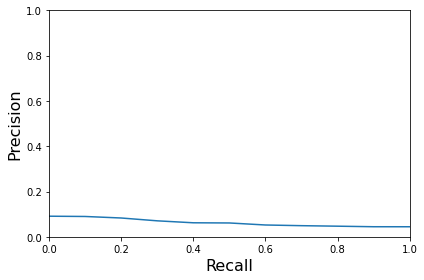

[0.09097517 0.08976547 0.0830514  0.0705543  0.06189567 0.06109219
 0.05215344 0.049135   0.04686932 0.04445627 0.04437735]
1000/1000 [==============================] - 97s 97ms/step - loss: 910728.0000 - accuracy: 0.6366
Epoch 44/50
1000/1000 [==============================] - ETA: 0s - loss: 762764.4375 - accuracy: 0.6517
Epoch 00044: saving model to ./doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 40s 40ms/step


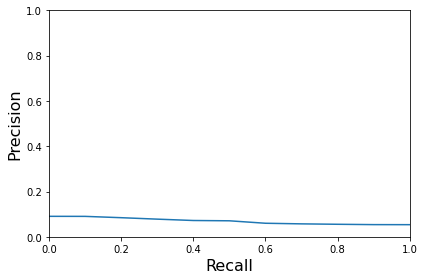

[0.09043552 0.0902168  0.08440021 0.07798895 0.07200017 0.07068627
 0.05984203 0.05714826 0.05532023 0.05379112 0.05356077]
1000/1000 [==============================] - 97s 97ms/step - loss: 762764.4375 - accuracy: 0.6517
Epoch 45/50
1000/1000 [==============================] - ETA: 0s - loss: 192690.6875 - accuracy: 0.6613
Epoch 00045: saving model to ./doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 40s 40ms/step


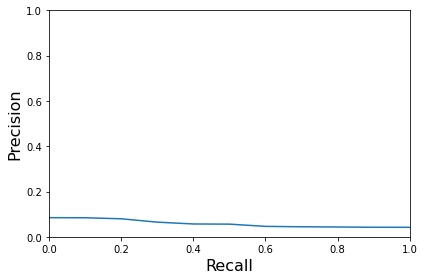

[0.08447589 0.08412051 0.07959463 0.06474963 0.0566538  0.05593215
 0.04607057 0.04430519 0.04331884 0.04211755 0.04189905]
1000/1000 [==============================] - 96s 96ms/step - loss: 192690.6875 - accuracy: 0.6613
Epoch 46/50
1000/1000 [==============================] - ETA: 0s - loss: 826104.6250 - accuracy: 0.6574
Epoch 00046: saving model to ./doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 40s 40ms/step


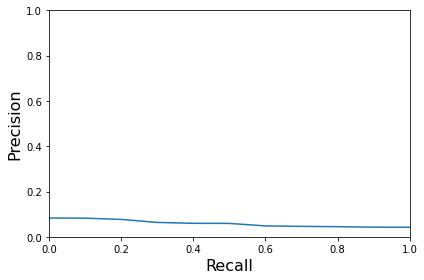

[0.08288736 0.08236538 0.07674521 0.06347564 0.05962791 0.05916929
 0.04806865 0.04602488 0.04467638 0.04244313 0.04212071]
1000/1000 [==============================] - 96s 96ms/step - loss: 826104.6250 - accuracy: 0.6574
Epoch 47/50
1000/1000 [==============================] - ETA: 0s - loss: 14271.1250 - accuracy: 0.6736
Epoch 00047: saving model to ./doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 39s 39ms/step


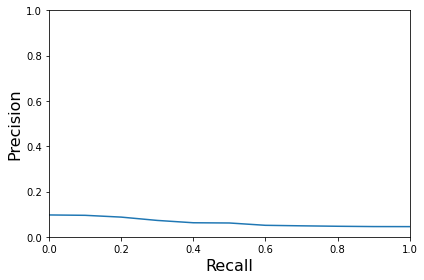

[0.09649102 0.09489762 0.08696371 0.0723503  0.06203125 0.06100445
 0.05076342 0.04847182 0.04653229 0.04519106 0.04493331]
1000/1000 [==============================] - 96s 96ms/step - loss: 14271.1250 - accuracy: 0.6736
Epoch 48/50
1000/1000 [==============================] - ETA: 0s - loss: 16414.5020 - accuracy: 0.6698
Epoch 00048: saving model to ./doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 39s 39ms/step


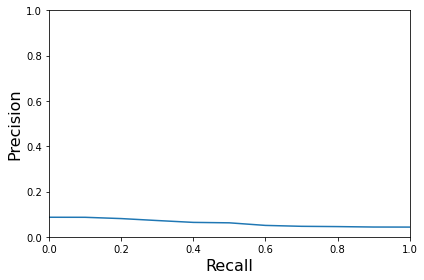

[0.08634216 0.08612788 0.08048435 0.07186165 0.06365542 0.06170915
 0.0503248  0.0463256  0.04507457 0.04315325 0.04288877]
1000/1000 [==============================] - 96s 96ms/step - loss: 16414.5020 - accuracy: 0.6698
Epoch 49/50
1000/1000 [==============================] - ETA: 0s - loss: 46081232896.0000 - accuracy: 0.6383
Epoch 00049: saving model to ./doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 40s 40ms/step


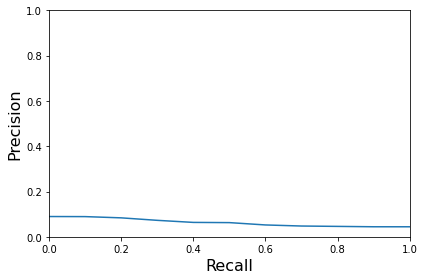

[0.08953925 0.08915592 0.08370608 0.07273586 0.06359049 0.06264851
 0.05234266 0.04758188 0.045978   0.04432545 0.04424709]
1000/1000 [==============================] - 96s 96ms/step - loss: 46081232896.0000 - accuracy: 0.6383
Epoch 50/50
1000/1000 [==============================] - ETA: 0s - loss: 55689464.0000 - accuracy: 0.5476
Epoch 00050: saving model to ./doublelstmcheckpoint1.h5
131
1000/1000 [==============================] - 40s 40ms/step


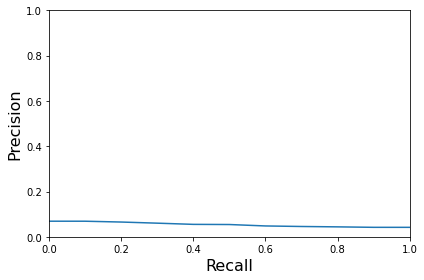

[0.06888319 0.06881653 0.06519472 0.06020572 0.05493972 0.0542207
 0.04793161 0.04554436 0.04389399 0.04183481 0.04178442]
1000/1000 [==============================] - 96s 96ms/step - loss: 55689464.0000 - accuracy: 0.5476


<Figure size 432x288 with 0 Axes>

In [84]:
history = model.fit(lstm_dataset, epochs=50, steps_per_epoch=1000, callbacks=[cp_callback, prc_callback])

In [18]:
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"])

NameError: name 'history' is not defined

In [ ]:

generate_prc()